In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# вариант
p = 0.1
window = np.array([[2, 1, 2], [1, 1, 1], [2, 1, 2]]) * 1 / 13

In [3]:
def add_noise(pixels, threshold):
    index = np.random.rand(pixels.shape[0], pixels.shape[1])
    result = np.copy(pixels)
    result[index < threshold] = 255
    return result

In [4]:
cat = cv2.imread('/content/original1.jpg')
cat_gray = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
cat_noise = add_noise(cat_gray, p)

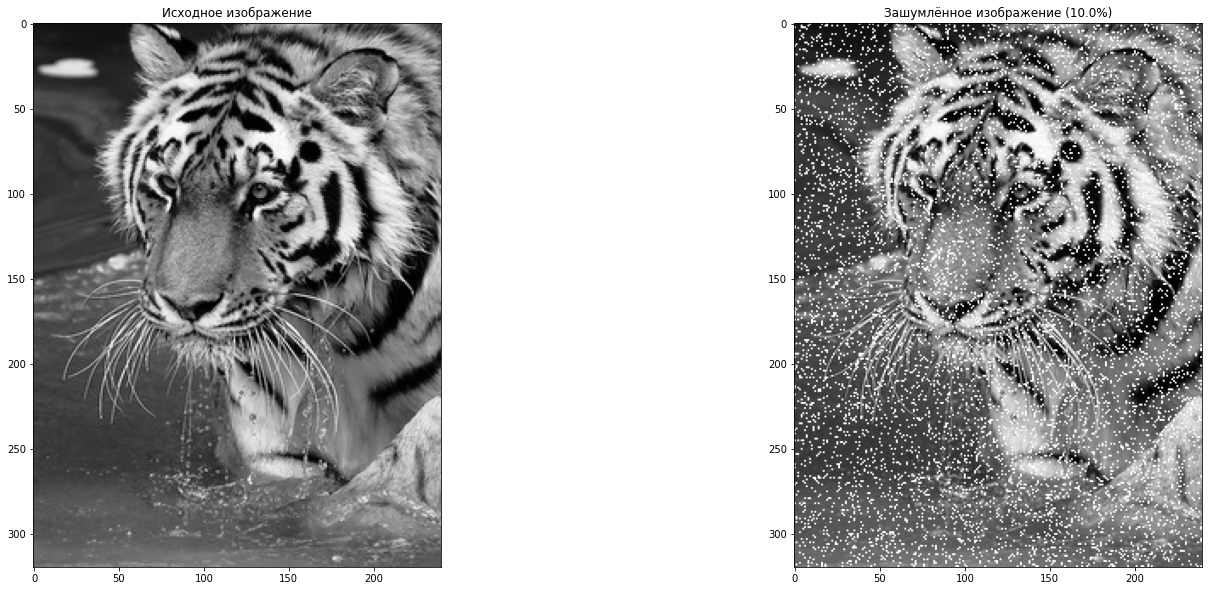

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

ax[0].imshow(cat_gray, vmin=0, vmax=255,  cmap='Greys_r')
ax[0].set(title='Исходное изображение')
ax[1].imshow(cat_noise, vmin=0, vmax=255,  cmap='Greys_r')
ax[1].set(title='Зашумлённое изображение ({}%)'.format(p * 100))

plt.show()

#КИХ-фильтр

In [6]:
# КИХ = finite impulse response (FIR) filter

def fir_filter_image(image, weighted_window):
  return cv2.merge(list(map(lambda channel: fir_filter(channel, weighted_window), cv2.split(image))))

def fir_filter(image, weighted_window):
  h, w = image.shape
  window_h, window_w = weighted_window.shape
  new_image = np.zeros((h, w), np.uint8)
  # ddepth = -1, выходное изображение имеет ту же глубину, что и исходное
  new_image = cv2.filter2D(image, -1, weighted_window)
  return new_image

In [7]:
def get_error(img1, img2):
    img1 = img1 / 255
    img2 = img2 / 255
    h, w = img1.shape[0], img1.shape[1]
    return (np.sum((np.array(img1.flatten()) - np.array(img2.flatten())) ** 2) / (h * w * 3)) ** 0.5

Error: 0.06829615460758705


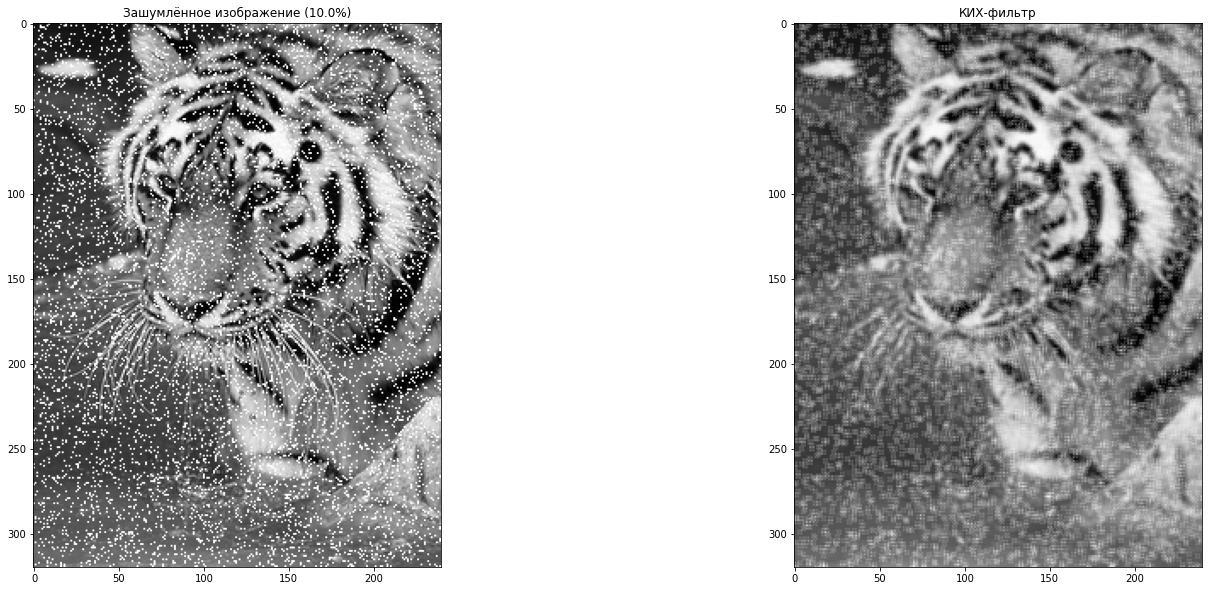

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

cat_fir = fir_filter_image(cat_noise, window)
print("Error:", get_error(cat_gray, cat_fir))
ax[0].imshow(cat_noise, vmin=0, vmax=255, cmap='Greys_r')
ax[0].set(title='Зашумлённое изображение ({}%)'.format(p * 100))
ax[1].imshow(cat_fir, vmin=0, vmax=255,  cmap='Greys_r')
ax[1].set(title='КИХ-фильтр')
plt.show()

# Спектры

In [9]:
tuple([slice(0, int(sz)) for sz in np.array(cat_gray.shape)])

(slice(0, 320, None), slice(0, 240, None))

In [10]:
2 ** np.ceil(np.log2(np.array(cat_gray.shape))).astype(int)

array([512, 256])

In [11]:
def filtering_fft(image, kernel):
  
  s1 = np.array(image.shape)

  fsize = 2 ** np.ceil(np.log2(s1)).astype(int)
  fslice = tuple([slice(0, int(sz)) for sz in s1])

  image_fft = np.fft.fft2(image , fsize)

  kernel_fft = np.fft.fft2(kernel , fsize)
  result = np.fft.ifft2(image_fft * kernel_fft)[fslice].copy()

  return np.array(result.real , np.int32)

Error: 0.07610681774022937


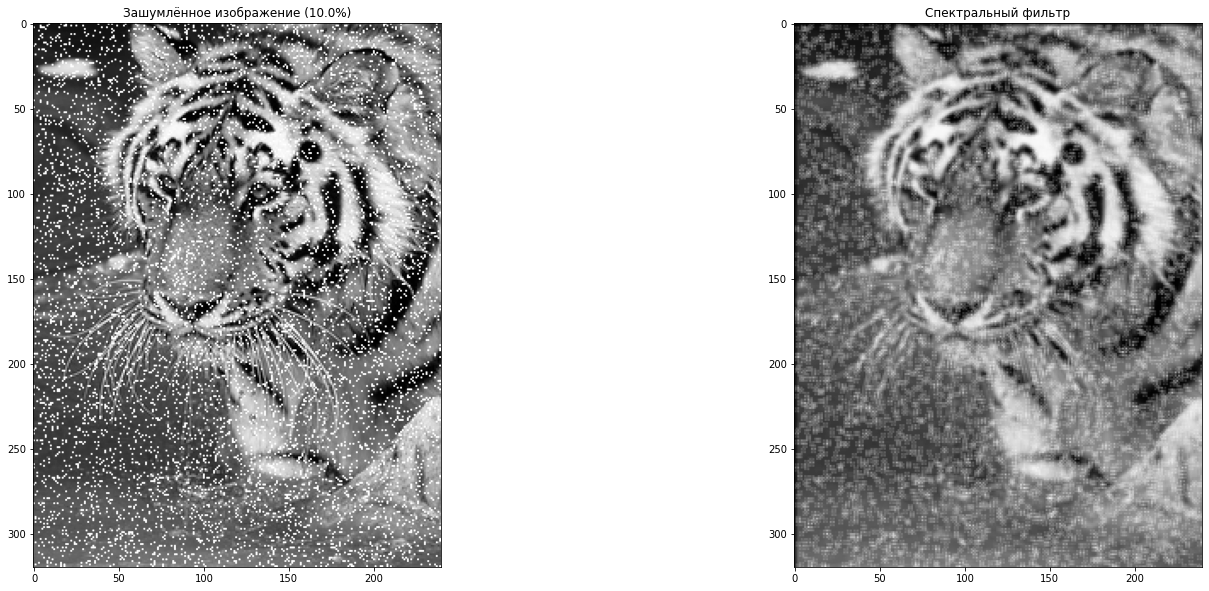

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

cat_spectral =  filtering_fft(cat_noise, window)
print("Error:", get_error(cat_gray, cat_spectral))
ax[0].imshow(cat_noise, vmin=0, vmax=255, cmap='Greys_r')
ax[0].set(title='Зашумлённое изображение ({}%)'.format(p * 100))
ax[1].imshow(cat_spectral, vmin=0, vmax=255, cmap='Greys_r')
ax[1].set(title='Спектральный фильтр')
plt.show()

In [13]:
cat_spectral.shape

(320, 240)

In [14]:
cat_noise.shape

(320, 240)